In [226]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Objective

In the era of digital streaming, there’s an increasing need to categorize and recommend music based on genres. By analyzing various musical features extracted from tracks, we can delve deeper into their defining patterns. In this music genre classification project, you’ll work with a dataset containing various musical features extracted from tracks across different styles.

To accomplish this, we’ll employ Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. By transforming the abundant features into principal components, we’ll streamline the data, making it more manageable and revealing patterns that are not immediately obvious in the raw data. The principal components we’ve derived will form the foundation for the next step in the project—employing a supervised machine learning algorithm, with a focus on the well-known logistic regression technique.

## Why Principal Component Analysis (PCA)?

Music tracks are complex entities with numerous inherent features. Some of these features might be correlated. For instance, specific rhythm patterns might be prevalent in rock and blues. In this machine learning project, PCA can assist in reducing redundancy by transforming correlated musical features into a set of linearly uncorrelated variables or principal components. Reducing dimensionality can drastically improve the performance of classification algorithms by eliminating noise.

The features in the music genre classification dataset are designed to be intuitive and accessible allowing you to focus on the core concepts of PCA and machine learning without the need for specialized audio knowledge.

# Load and prepare the dataset

In [227]:
data_leg = pd.read_excel(r"C:\Users\minek\PycharmProjects\music_genre_classification\Music Data Legend.xlsx", header=3)

In [228]:
data_leg = data_leg.drop('Unnamed: 0', axis=1).dropna()

In [229]:
# This data shows genres, their data types and their description.
data_leg

,Variable,Data Type,Description
0,Tempo,numerical,Beats per minute (BPM) of the track.
2,Dynamic Range,numerical,The range between the quietest and loudest par...
4,Vocal Presence,numerical,The prominence of vocals in a track.
6,Percussion Strength,numerical,the intensity and presence of percussion inst...
8,String Instrument Detection,numerical,The presence and prominence of string instrume...
10,Electronic Element Presence,numerical,The intensity and presence of percussion instr...
12,Rhythm Complexity,numerical,The complexity and variation in a track's rhyt...
14,Drums Influence:,numerical,The drums contribution to the overall sound of...
16,Distorted Guitar,numerical,The extent to which electronic sounds or synth...
18,Metal Frequencies,numerical,"The use of distorted guitar sounds, often asso..."


In [230]:
data = pd.read_csv(r"C:\Users\minek\PycharmProjects\music_genre_classification\music_dataset_mod.csv")

In [231]:
df = data.copy()

In [232]:
# In this dataset, there are 1000 songs with their attributes.
df.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,Country
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,Classical
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,Rock
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,Hip-hop
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,Country


## Inspect the data (info)

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tempo                        1000 non-null   float64
 1   Dynamics Range               1000 non-null   float64
 2   Vocal Presence               1000 non-null   float64
 3   Percussion Strength          1000 non-null   float64
 4   String Instrument Detection  1000 non-null   float64
 5   Electronic Element Presence  1000 non-null   float64
 6   Rhythm Complexity            1000 non-null   float64
 7   Drums Influence              1000 non-null   float64
 8   Distorted Guitar             1000 non-null   float64
 9   Metal Frequencies            1000 non-null   float64
 10  Ambient Sound Influence      1000 non-null   float64
 11  Instrumental Overlaps        1000 non-null   float64
 12  Genre                        890 non-null    object 
dtypes: float64(12), obj

In [234]:
# Missing values are only in "Genre" column. We don't know 110 songs' genres. We're gonna predict them later.
df.isna().sum()

Tempo                            0
Dynamics Range                   0
Vocal Presence                   0
Percussion Strength              0
String Instrument Detection      0
Electronic Element Presence      0
Rhythm Complexity                0
Drums Influence                  0
Distorted Guitar                 0
Metal Frequencies                0
Ambient Sound Influence          0
Instrumental Overlaps            0
Genre                          110
dtype: int64

## Discover Music Genres (unique)

In [235]:
df["Genre"].nunique()

5

In [236]:
# In this dataset, there are 5 different genres and there are also the ones with the NAN values.
df["Genre"].unique()

array(['Country', 'Classical', 'Rock', 'Hip-hop', nan, 'Jazz'],
      dtype=object)

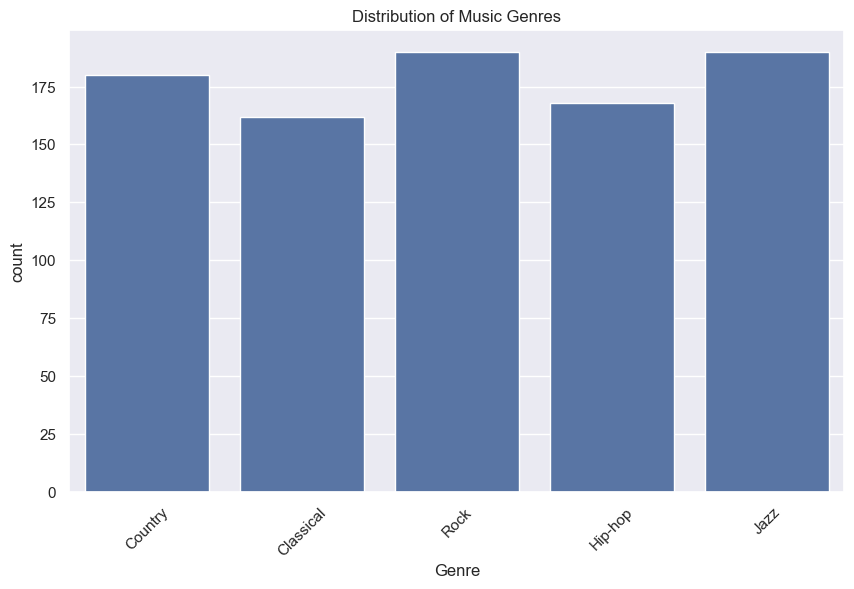

In [237]:
# As we can see below, our dataset (target variable) is balanced.
# Plot the distribution of genres
plt.figure(figsize=(10, 6))
sns.countplot(x='Genre', data=df)
plt.xticks(rotation=45)
plt.title('Distribution of Music Genres')
plt.show()

## Prepare the data

In [238]:
# We split the observation with NA Genre column
df_clean = df[~(df['Genre'].isna())]

In [239]:
df_clean.isna().sum()

Tempo                          0
Dynamics Range                 0
Vocal Presence                 0
Percussion Strength            0
String Instrument Detection    0
Electronic Element Presence    0
Rhythm Complexity              0
Drums Influence                0
Distorted Guitar               0
Metal Frequencies              0
Ambient Sound Influence        0
Instrumental Overlaps          0
Genre                          0
dtype: int64

## Split Data

In [240]:
# Separate features and target variable
X = df_clean.drop(columns=['Genre'])
y = df_clean['Genre']

In [241]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the Genre column
y_encoded = label_encoder.fit_transform(y)

# Add the encoded Genre as a new column to the DataFrame
df_clean['Genre_encoded'] = y_encoded

# Drop the original Genre column
df_encoded = df_clean.drop(columns=['Genre'])

C:\Users\minek\AppData\Local\Temp\ipykernel_32716\3712308929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Genre_encoded'] = y_encoded


In [242]:
# Display the first few rows of the updated DataFrame
df_encoded.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre_encoded
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,1
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,0
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,4
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,2
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,1


## Correlation Matrix and Heatmap

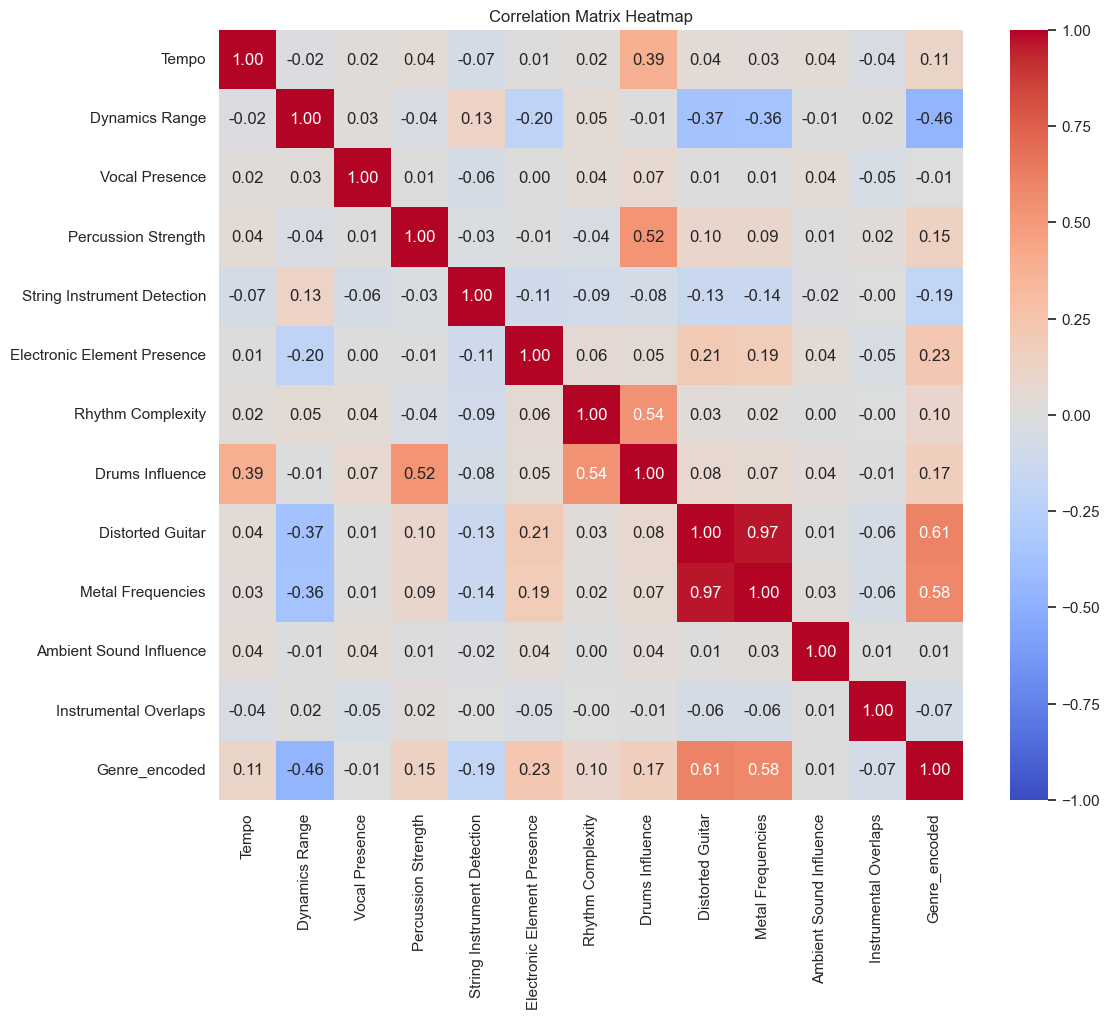

In [243]:
# We want to see the correlation between the features

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

* **Strong Correlations:** Distorted guitar and metal frequencies show strong correlations with the genre encoding, suggesting these features are significant in genre classification. <br>
* **Weak or No Correlations:** Many features show weak correlations with genre encoding, indicating that these features might not be as critical for distinguishing between genres.

## Standardize the Data

In [244]:
# Separate features from the target column
X = df_encoded.drop(columns=['Genre_encoded'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Apply PCA

In [245]:
# Create PCA instance (without specifying the number of components)
pca = PCA()

# Fit and transform the scaled data
X_pca = pca.fit_transform(X_scaled)


In [246]:
# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative variance
cumulative_variance = explained_variance_ratio.cumsum()


Plot the cumulative variance to help determine how many components are needed to capture at least 80% of the variance.

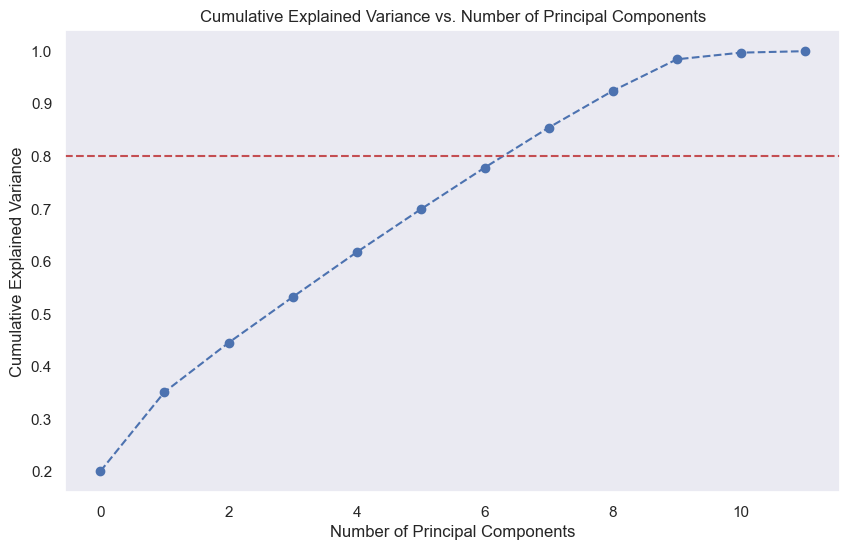

In [247]:
import matplotlib.pyplot as plt

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

## Reapply PCA with Chosen Components

In [248]:
# Choose the number of components based on the cumulative variance plot
n_components = 6  

# Reapply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Optionally, print the explained variance to confirm
print(f'Explained variance by each component: {pca.explained_variance_ratio_}')
print(f'Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}')


Explained variance by each component: [0.20063071 0.15062807 0.09369199 0.08696907 0.08536054 0.08167379]
Cumulative explained variance: [0.20063071 0.35125878 0.44495077 0.53191983 0.61728037 0.69895416]


## PCA-Transformed Features

In [249]:
df_encoded.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre_encoded
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,1
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,0
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,4
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,2
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,1


### Split PCA Data into Training and Test Sets

In [250]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.30, random_state=42)

### Train Logistic Regression on PCA Data

In [251]:
# Initialize Logistic Regression model
lr_pca = LogisticRegression(max_iter=10000, random_state=42)

# Fit the model
lr_pca.fit(X_train_pca, y_train)


LogisticRegression(max_iter=10000, random_state=42)

### Evaluate PCA Model

In [252]:
# Predict on the test set
y_pred_pca = lr_pca.predict(X_test_pca)

# Calculate accuracy and classification report
accuracy_pca = accuracy_score(y_test, y_pred_pca)
report_pca = classification_report(y_test, y_pred_pca)

print("PCA Model Accuracy:", accuracy_pca)
print("PCA Model Classification Report:\n", report_pca)


PCA Model Accuracy: 0.5205992509363296
PCA Model Classification Report:
               precision    recall  f1-score   support

   Classical       0.88      0.96      0.92        51
     Country       0.38      0.35      0.36        52
     Hip-hop       0.42      0.31      0.36        48
        Jazz       0.40      0.39      0.39        62
        Rock       0.49      0.61      0.54        54

    accuracy                           0.52       267
   macro avg       0.51      0.52      0.51       267
weighted avg       0.51      0.52      0.51       267



## Original Features

### Split Original Scaled Features into Training and Test Sets

In [253]:
X_train_original, X_test_original, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

### Train Logistic Regression on Original Data

In [254]:
# Initialize Logistic Regression model
lr_original = LogisticRegression(max_iter=10000, random_state=42)

# Fit the model
lr_original.fit(X_train_original, y_train)

LogisticRegression(max_iter=10000, random_state=42)

### Evaluate Original Model

In [255]:
# Predict on the test set
y_pred_original = lr_original.predict(X_test_original)

# Calculate accuracy and classification report
accuracy_original = accuracy_score(y_test, y_pred_original)
report_original = classification_report(y_test, y_pred_original)

print("Original Model Accuracy:", accuracy_original)
print("Original Model Classification Report:\n", report_original)

Original Model Accuracy: 0.5318352059925093
Original Model Classification Report:
               precision    recall  f1-score   support

   Classical       0.86      1.00      0.93        51
     Country       0.33      0.25      0.29        52
     Hip-hop       0.45      0.46      0.45        48
        Jazz       0.44      0.39      0.41        62
        Rock       0.49      0.59      0.54        54

    accuracy                           0.53       267
   macro avg       0.52      0.54      0.52       267
weighted avg       0.51      0.53      0.52       267



## Prepare Data for Prediction

In [256]:
# Extract rows with missing Genre information
df_missing_genre = df[df['Genre'].isna()]

In [257]:
# Drop the Genre column
X_missing = df_missing_genre.drop(columns=['Genre'])

# Standardize the features
X_missing_scaled = scaler.transform(X_missing)

# Apply PCA transformation if PCA was used
X_missing_pca = pca.transform(X_missing_scaled)


## Apply the Model for Prediction

In [263]:
# Predict genres using the original features model because original model accuracy (0.53) is greater than the one with PCA
y_pred_labels = lr_original.predict(X_missing_scaled)

In [264]:
y_pred_labels

array(['Classical', 'Country', 'Country', 'Hip-hop', 'Rock', 'Jazz',
       'Jazz', 'Jazz', 'Rock', 'Hip-hop', 'Jazz', 'Rock', 'Rock',
       'Hip-hop', 'Rock', 'Country', 'Hip-hop', 'Jazz', 'Hip-hop', 'Rock',
       'Hip-hop', 'Rock', 'Classical', 'Jazz', 'Country', 'Jazz',
       'Classical', 'Hip-hop', 'Classical', 'Jazz', 'Classical',
       'Country', 'Jazz', 'Rock', 'Rock', 'Rock', 'Country', 'Classical',
       'Hip-hop', 'Country', 'Jazz', 'Classical', 'Classical', 'Country',
       'Rock', 'Country', 'Hip-hop', 'Jazz', 'Classical', 'Jazz',
       'Country', 'Jazz', 'Classical', 'Country', 'Rock', 'Country',
       'Hip-hop', 'Rock', 'Country', 'Country', 'Hip-hop', 'Classical',
       'Classical', 'Classical', 'Country', 'Rock', 'Jazz', 'Classical',
       'Country', 'Country', 'Jazz', 'Country', 'Country', 'Rock',
       'Classical', 'Rock', 'Jazz', 'Jazz', 'Country', 'Country', 'Rock',
       'Classical', 'Rock', 'Classical', 'Classical', 'Rock', 'Classical',
       'Country

In [ ]:
# # If predicted label is numeric, convert numeric predictions back to original genre labels
# y_pred_labels = label_encoder.inverse_transform(y_pred_numeric)

In [265]:
# Fill in missing Genre values with predictions
df.loc[df['Genre'].isna(), 'Genre'] = y_pred_labels

In [268]:
# Display the DataFrame to check if missing genres are filled
df.isna().sum()

Tempo                          0
Dynamics Range                 0
Vocal Presence                 0
Percussion Strength            0
String Instrument Detection    0
Electronic Element Presence    0
Rhythm Complexity              0
Drums Influence                0
Distorted Guitar               0
Metal Frequencies              0
Ambient Sound Influence        0
Instrumental Overlaps          0
Genre                          0
dtype: int64

In [269]:
df.head()

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
0,114.618354,57.976367,53.251766,99.061840,14.686768,17.628630,46.545522,75.839434,79.378892,71.753088,96.439665,53.771763,Country
1,116.672803,69.387087,95.787280,90.831033,47.280419,-15.618194,85.421085,100.455908,0.713015,0.000000,17.327295,15.017146,Classical
2,128.328121,52.930677,65.701187,104.439247,5.984994,50.467388,18.006722,77.642913,80.652946,87.692110,95.125207,25.308020,Rock
3,128.511337,25.494755,14.095374,40.106130,47.715584,87.335201,68.603329,63.536557,74.888346,76.239108,97.016998,96.893109,Hip-hop
4,135.474190,45.174876,101.469872,70.002203,108.177637,25.865590,31.295163,81.121030,36.178193,23.381542,53.753793,30.142986,Country


In [272]:
df[992:993]

,Tempo,Dynamics Range,Vocal Presence,Percussion Strength,String Instrument Detection,Electronic Element Presence,Rhythm Complexity,Drums Influence,Distorted Guitar,Metal Frequencies,Ambient Sound Influence,Instrumental Overlaps,Genre
992,117.892313,35.001524,76.506358,77.97257,80.765657,13.759213,59.985923,80.108786,93.831262,100.0,15.851851,47.984445,Rock
